In [2]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
import random
from random import randint
import string
import nltk
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import time
import io
import collections
import math
import argparse
import pickle as pkl
from tqdm import tqdm, tqdm_notebook

In [3]:
from GetData import getData

data_rows,X,Y=getData()

In [57]:
from collections import Counter
counter=Counter(Y)

In [58]:
counter

Counter({'Recovering': 123,
         'Addicted': 275,
         'Recovered': 163,
         'Addiction-prone': 34,
         'NA': 132})

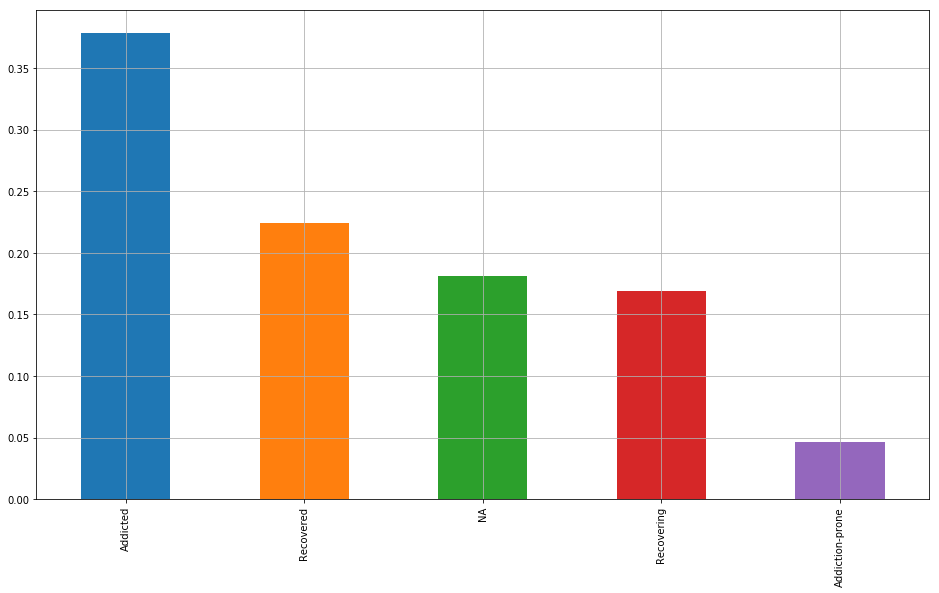

In [59]:
# Plotting the Distribution of Labels
dataframe = pd.DataFrame.from_dict(data_rows)
dataframe.y.value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(16, 9))

## Getting Tf-Idf features

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='utf-8', ngram_range=(1, 2), stop_words='english')
def getFeatures(X):
    features = tfidf.fit_transform(X).toarray() 
    return features
features=getFeatures(X)    


In [5]:
# dim(features)=len(X)*num_unique_tokens
tfidf_dict = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
tfidf_dict = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf_dict), orient='index')
tfidf_dict.columns = ['tfidf']

In [6]:
tfidf_dict.sort_values(by=['tfidf'], ascending=False)

,tfidf
00,6.897154
persisted hours,6.897154
persist,6.897154
perpetuates changes,6.897154
perpetuates,6.897154
perpetrator victim,6.897154
perpetrator seen,6.897154
permissiongiving thoughts,6.897154
permissiongiving,6.897154
permeable membranes,6.897154


In [15]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(features)

svd_tfidf.shape
run = True
if run:
# run this (takes times)
    from sklearn.manifold import TSNE
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
    tsne_tfidf = tsne_model.fit_transform(svd_tfidf)
    print(tsne_tfidf.shape)
    tsne_tfidf_df = pd.DataFrame(tsne_tfidf)
    tsne_tfidf_df.columns = ['x', 'y']
    tsne_tfidf_df['Y'] = data_rows['y']
    tsne_tfidf_df['X'] = data_rows['body']
    tsne_tfidf_df.to_csv('./../data/tsne_tfidf.csv', encoding='utf-8', index=False)
else:
# or import the dataset directly
    tsne_tfidf_df = pd.read_csv('./../data/tsne_tfidf.csv')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 727 samples in 0.042s...
[t-SNE] Computed neighbors for 727 samples in 0.090s...
[t-SNE] Computed conditional probabilities for sample 727 / 727
[t-SNE] Mean sigma: 0.087415
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.262741
[t-SNE] Error after 500 iterations: 1.714218
(727, 2)


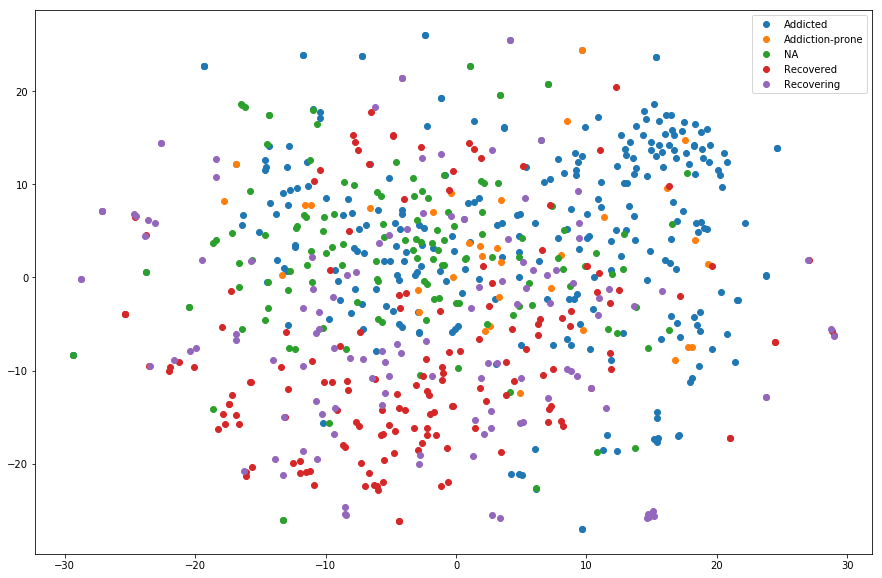

In [19]:
groups = tsne_tfidf_df.groupby('Y')
fig, ax = plt.subplots(figsize=(15, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend()
plt.show()

In [22]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file

from bokeh.resources import INLINE
import bokeh.io
bokeh.io.output_notebook(INLINE) 

Loading BokehJS ...

In [23]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="tf-idf clustering of reddit posts",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

palette = d3['Category10'][len(tsne_tfidf_df['Y'].unique())]
color_map = bmo.CategoricalColorMapper(factors=tsne_tfidf_df['Y'].map(str).unique(), palette=palette)

plot_tfidf.scatter(x='x', y='y', color={'field': 'Y', 'transform': color_map}, 
                   legend='Y', source=tsne_tfidf_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"x": "@X", "y":"@Y"}

show(plot_tfidf)

Loading BokehJS ...

In [69]:
import warnings
import statistics
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
distorsions = []
sil_scores = []

num_clusters = 5
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, random_state=42,                       
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000, )
kmeans = kmeans_model.fit(features)
kmeans_clusters = kmeans.predict(features)
kmeans_distances = kmeans.transform(features)



In [70]:
clustering=dict()
for (i, desc),category in zip(enumerate(data_rows['body']),data_rows['y']):
    if kmeans_clusters[i] in clustering:
        clustering[kmeans_clusters[i]].append(category)
    else:
        clustering[kmeans_clusters[i]]=[category]
for key in clustering.keys():
    clustering[key]=statistics.mode(clustering[key])
print(clustering)

sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
all_keywords = []
for i in range(num_clusters):
    topic_keywords = []
    for j in sorted_centroids[i, :10]:
        topic_keywords.append(terms[j])
    all_keywords.append(topic_keywords)

keywords_df = pd.DataFrame(index=['topic_{0}'.format(i) for i in range(num_clusters)], 
                           columns=['keyword_{0}'.format(i) for i in range(10)],
                           data=all_keywords)
keywords_df

{2: 'Recovering', 3: 'Addicted', 1: 'Addicted', 4: 'NA', 0: 'Recovered'}


,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9
topic_0,today,year,sober today,sober,years,clean today,clean,sobriety,year sober,years clean
topic_1,im,dont,know,like,just,feel,think,time,want,feeling
topic_2,days,day,today,years,sober,clean,stay,90 days,90,im
topic_3,just,im,time,like,years,life,clean,today,ive,drugs
topic_4,weekend,tonight,friday,check,wife,night,evening,rdrugsover30,hot,maybe time


In [71]:
# CHANGING CLUSTERS To 3
num_clusters=3
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, random_state=42,                       
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000, )
kmeans = kmeans_model.fit(features)
kmeans_clusters = kmeans.predict(features)
kmeans_distances = kmeans.transform(features)

clustering=dict()
for (i, desc),category in zip(enumerate(data_rows['body']),data_rows['y']):
    if kmeans_clusters[i] in clustering:
        clustering[kmeans_clusters[i]].append(category)
    else:
        clustering[kmeans_clusters[i]]=[category]
for key in clustering.keys():
    clustering[key]=statistics.mode(clustering[key])
print(clustering)

sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
all_keywords = []
for i in range(num_clusters):
    topic_keywords = []
    for j in sorted_centroids[i, :10]:
        topic_keywords.append(terms[j])
    all_keywords.append(topic_keywords)

keywords_df = pd.DataFrame(index=['topic_{0}'.format(i) for i in range(num_clusters)], 
                           columns=['keyword_{0}'.format(i) for i in range(10)],
                           data=all_keywords)
keywords_df

{2: 'Recovered', 1: 'Addicted', 0: 'Recovered'}


,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9
topic_0,today,year,sober,clean,clean today,sober today,years,sobriety,year sober,years clean
topic_1,just,im,like,time,life,know,years,dont,drugs,people
topic_2,days,clean,years,today,im,day,years clean,sober,days clean,ive


## Latent Dirichlet Allocation

In [27]:
import gensim
import gensim.corpora as corpora
from gensim import matutils
from gensim.models import CoherenceModel
aux = data_rows.copy()

bigram = gensim.models.Phrases(aux['tokens'], min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
aux['tokens_bigram'] = [bigram_mod[tokens] for tokens in aux['tokens']]

id2word = corpora.Dictionary(aux['tokens_bigram'])
texts = aux['tokens_bigram']
corpus = [id2word.doc2bow(text) for text in texts]


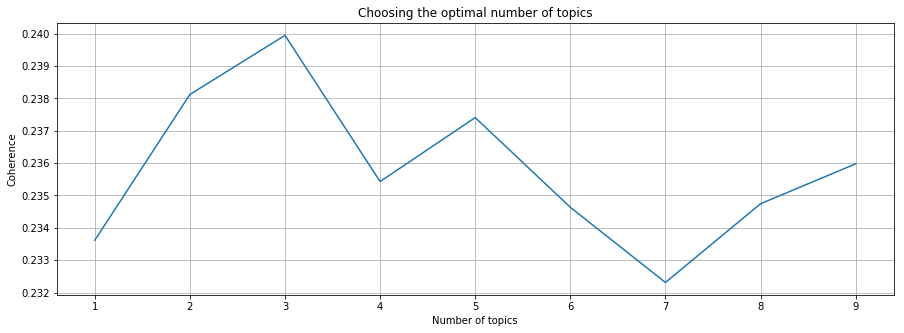

In [28]:

def LDA_model(num_topics, passes=1):
    return gensim.models.ldamodel.LdaModel(corpus=tqdm_notebook(corpus, leave=False),
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               eval_every=10,
                                               chunksize=2000,
                                               passes=passes,
                                               per_word_topics=True
                                            )
def compute_coherence(model):
    coherence = CoherenceModel(model=model, 
                           texts=aux['tokens_bigram'],
                           dictionary=id2word, coherence='c_v')
    return coherence.get_coherence()



def explore_models(df, rg=range(1, 10)):
    id2word = corpora.Dictionary(df['tokens_bigram'])
    texts = df['tokens_bigram']
    corpus = [id2word.doc2bow(text) for text in texts]

    models = []
    coherences = []
    
    for num_topics in tqdm_notebook(rg, leave=False):
        lda_model = LDA_model(num_topics, passes=5)
        models.append(lda_model)
        coherence = compute_coherence(lda_model)
        coherences.append(coherence)
      

    fig = plt.figure(figsize=(15, 5))
    plt.title('Choosing the optimal number of topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence')
    plt.grid(True)
    plt.plot(rg, coherences)
    
    return coherences, models

coherences, models = explore_models(aux)

In [29]:
def display_topics(model):
    topics = model.show_topics(num_topics=model.num_topics, formatted=False, num_words=10)
    topics = list(map(lambda c: map(lambda cc: cc[0], c[1]), topics))
    df = pd.DataFrame(topics)
    df.index = ['topic_{0}'.format(i) for i in range(model.num_topics)]
    df.columns = ['keyword_{0}'.format(i) for i in range(1, 10+1)]
    return df
best_model = LDA_model(num_topics=3, passes=5)
display_topics(model=best_model)

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10
topic_0,i,to,the,and,a,you,of,it,my,that
topic_1,the,i,my,of,a,to,and,was,in,is
topic_2,i,and,the,to,a,of,my,was,it,in


In [30]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(best_model, corpus, id2word)
pyLDAvis.display(panel)

/home/cules/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


# Supervised Clasification

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
seed = 21
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
f_cvscores = []
prec_cvscores = []
recall_cvscores = []
labels=np.asarray(Y)
X=features
iteration=0

## SVM

In [65]:
from sklearn.svm import SVC
for train_ind, test_ind in kfold.split(X, labels):
    print("Iteration,", iteration)
    iteration+=1
    clf =  SVC(kernel='linear').fit(X[train_ind], labels[train_ind])
    y_pred=clf.predict(X[test_ind])
    f_cvscores.append(precision_recall_fscore_support(labels[test_ind],y_pred,average='weighted')[2])
    prec_cvscores.append(precision_recall_fscore_support(labels[test_ind],y_pred,average='weighted')[0])
    recall_cvscores.append(precision_recall_fscore_support(labels[test_ind],y_pred,average='weighted')[1])
print("Precision: ",np.mean(prec_cvscores)," Recall: ",np.mean(recall_cvscores)," F-score: ",np.mean(f_cvscores))

Iteration, 0
Iteration, 1


/home/cules/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration, 2
Iteration, 3
Iteration, 4
Iteration, 5
Iteration, 6
Iteration, 7
Iteration, 8
Iteration, 9
Precision:  0.5558890903199749  Recall:  0.5721610060104276  F-score:  0.4856274573446484


In [66]:
f_cvscores = []
prec_cvscores = []
recall_cvscores = []
iteration=0
_,X,_=getData()
X_stemmed=getFeatures(X)
from sklearn.svm import SVC
for train_ind, test_ind in kfold.split(X_stemmed, labels):
    print("Iteration,", iteration)
    iteration+=1
    clf =  SVC(kernel='rbf').fit(X_stemmed[train_ind], labels[train_ind])
    y_pred=clf.predict(X_stemmed[test_ind])
    f_cvscores.append(precision_recall_fscore_support(labels[test_ind],y_pred,average='weighted')[2])
    prec_cvscores.append(precision_recall_fscore_support(labels[test_ind],y_pred,average='weighted')[0])
    recall_cvscores.append(precision_recall_fscore_support(labels[test_ind],y_pred,average='weighted')[1])
print("Precision: ",np.mean(prec_cvscores)," Recall: ",np.mean(recall_cvscores)," F-score: ",np.mean(f_cvscores))

Iteration, 0


/home/cules/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration, 1
Iteration, 2
Iteration, 3
Iteration, 4
Iteration, 5
Iteration, 6
Iteration, 7
Iteration, 8
Iteration, 9
Precision:  0.1432270843627102  Recall:  0.3784034422025222  F-score:  0.20778989603781364


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 0)
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='prior',random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
prec,recall,fscore,_=precision_recall_fscore_support(y_test,y_pred,average='weighted')
print("Precision: ",prec," Recall: ",recall," F-score: ",fscore)

Precision:  0.15650283782151914  Recall:  0.3956043956043956  F-score:  0.2242796573505235


/home/cules/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Naive Bayes

In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB
seed = 21
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
f_cvscores = []
prec_cvscores = []
recall_cvscores = []
labels=np.asarray(labels)
X=features
for train_ind, test_ind in kfold.split(X, labels):
    clf = MultinomialNB().fit(X[train_ind], labels[train_ind])
    y_pred=clf.predict(X[test_ind])
    f_cvscores.append(precision_recall_fscore_support(labels[test_ind],y_pred,average='weighted')[2])
    recall_cvscores.append(precision_recall_fscore_support(labels[test_ind],y_pred,average='weighted')[1])
    prec_cvscores.append(precision_recall_fscore_support(labels[test_ind],y_pred,average='weighted')[0])

/home/cules/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
print("Precision: ",np.mean(prec_cvscores)," Recall: ",np.mean(recall_cvscores)," F-score: ",np.mean(f_cvscores))

Precision:  0.37474949608609864  Recall:  0.4693529154579806  F-score:  0.3501161187847835


## Neural Network

In [37]:
from sklearn.neural_network import MLPClassifier
seed = 21
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
f_cvscores = []
prec_cvscores = []
recall_cvscores = []
labels=np.asarray(labels)
X=features
for train_ind, test_ind in kfold.split(X, labels):
    clf = clf = MLPClassifier(solver='lbfgs', alpha=1e-4,early_stopping=True,hidden_layer_sizes=(50), random_state=1).fit(X[train_ind], labels[train_ind])
    y_pred=clf.predict(X[test_ind])
    f_cvscores.append(precision_recall_fscore_support(labels[test_ind],y_pred,average='weighted')[2])
    recall_cvscores.append(precision_recall_fscore_support(labels[test_ind],y_pred,average='weighted')[1])
    prec_cvscores.append(precision_recall_fscore_support(labels[test_ind],y_pred,average='weighted')[0])

/home/cules/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
print("Precision: ",np.mean(prec_cvscores)," Recall: ",np.mean(recall_cvscores)," F-score: ",np.mean(f_cvscores))

Precision:  0.6272954623745512  Recall:  0.6436094953926073  F-score:  0.6204873509513338
